# Chunking Guidance for Retireval Augmentation Generation 

Retrieval Augementation and Generation (RAG) systems are increasingly common. Generally it is easy to implement a proof of concept that passes the infamous "vibe" check fairly quickly, whilst this might get an engineer 70-80% of the way, as with any data driven system, the devil really is in the details when it comes to squeezing out the extra performance that gives end users confidence.

Through this notebook we'll look at how to best understand a corpus of documents, some analysis that can help determine some of the parameters of your chunking, and how to go about running experiments to see what really works for your data.

Naturally, RAG systems have a lot of components, where possible we'll  introduce core concepts, but we won't deep dive on everything here.

## Purpose

This notebook aims to give direction to data professionals in how they might approach evaluating, and selecting a chunking methodology for a RAG system. 

This notebook does NOT intend on covering end to end evaluation of RAG systems, as that is a much broader topic that dives into information retrieval. Resources for tuning those elements of a RAG system can be found [here]().

## Outline

1. Exploring your Corpus
2. Words, Tokens and Contexts
3. What is a chunk, and why are they important?
4. Experiments, and Experiment families
5. Preparing the data
6. Building a ground truth dataset
7. Experiment harness
8. Evaluation

Let's get started!

## Loading a Corpus

First things first, let's load some text data to work with. Let's go with the [pubmed summarisation dataset](https://huggingface.co/datasets/ccdv/pubmed-summarization). We'll download from hugging face, but for simplicity we'll convert the dataset to pandas, which most data pro's are familiar with.

In [4]:
# Imports

from datasets import load_dataset
from uuid import uuid4
from pprint import pprint
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tiktoken as tk
import random
import json
from multiprocessing import Pool

# Set to pubmed or arxiv
publication = 'pubmed'

dataset = load_dataset(f'ccdv/{publication}-summarization',split='validation',trust_remote_code=True)

# Convert to a pandas dataframe and do some housekeeping
ds = dataset.to_pandas()
ds['doc_id'] = [str(uuid4()) for _ in range(len(ds))]
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))

ds.drop(columns=['abstract'],inplace=True)

# Take a look at our data
ds.head()

,article,doc_id,article_len
0,venous thromboembolism ( vte ) comprising of d...,4470f50f-613c-44c7-9116-d87037608041,4320
1,there is an epidemic of stroke in low and midd...,eee23dbd-f45e-4a4a-909b-c3a40c146685,3485
2,cardiovascular diseases account for the highes...,e5c91fc4-4f66-4ffc-b4f3-72cf37e793c7,2939
3,results of a liquid culturing system ( bd bact...,dcdfd79a-0b03-4a84-9e42-8e20e9ce819b,1287
4,the need for magnetic resonance imaging ( mri ...,f10e7959-646d-4987-92b1-7e8ccfbd8322,5631


## Exploring your data

One of the main things that we are concerned with when building RAG systems is the length of the data that we intend to feed in to an LLM. Even with context windows (i.e. the length of the input + output to/from an LLM) are becoming increasingly large, but we still don't really know if simply throwing more data at an LLM effective, and it is definitely not quick.

Let's start by understanding just how long a typical article is, and get a feel for the boundaries and overall distribution of our data.

An easy way to do this is to look at some basic stats, and draw a histogram.

,article_len
count,6633.000000
mean,3112.306799
std,2776.940754
min,0.000000
25%,1523.000000
50%,2609.000000
75%,4011.000000
max,119269.000000


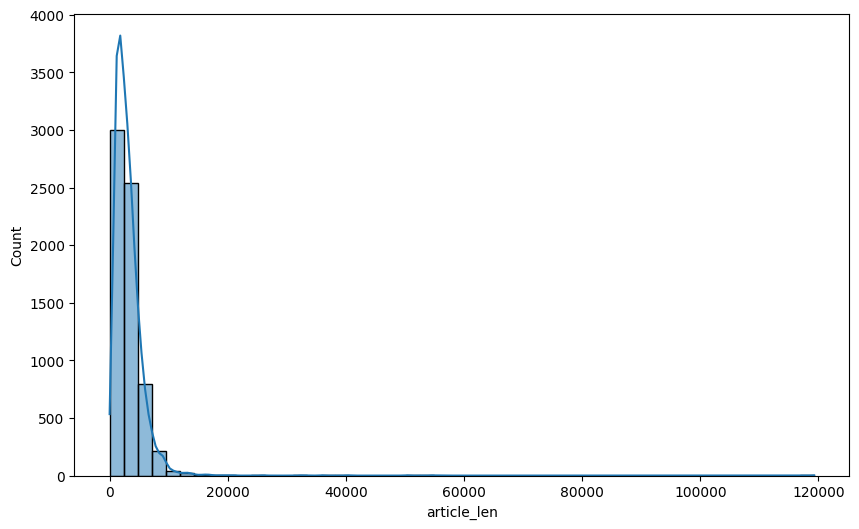

In [5]:
display(ds.describe())

fig = plt.figure(figsize=(10, 6))
sns.histplot(ds['article_len'], bins=50, kde=True)
plt.show()

Both the table and the diagram show what's called a heavy right skew - meaning that there are a small number of extremely large values. 

What we do with these extra long articles is an important decision. For some data problems you'd look to exclude outliers. But given this is an information retrieval problem, we'd like to keep as much data as possible. 

What we need to do, is understand  *why* some of these articles are so long, and deal with them accordingly

First, lets zoom in on the distribution and if we can find a more reasonable cut off point.

In [6]:
ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99])

,article_len
count,6633.000000
mean,3112.306799
std,2776.940754
min,0.000000
50%,2609.000000
75%,4011.000000
80%,4439.400000
90%,5661.000000
95%,6967.800000
99%,10231.720000


The problem is definitely in the high end of town, with a jump from 10k to 112k in number of words for the last percentile. Let's take a closer look at the raw data and see if we can tell what's going on.

In [7]:
# Get the indices of the articles with the longest length
longest_articles = ds['article_len'].nlargest(5).index
for idx in longest_articles:
    print(f'Article Length: {ds["article_len"][idx]}\n')
    print(ds['article'][idx]+'\n')
    print('\n')

Article Length: 119269

the motion of a point electric charge in flat spacetime was the subject of active investigation since the early work of lorentz , abrahams , and poincar , until dirac   produced a proper relativistic derivation of the equations of motion in 1938 . 
 ( the field s early history is well related in . ) in 1960 dewitt and brehme   generalized dirac s result to curved spacetimes , and their calculation was corrected by hobbs   several years later . in 1997 the motion of a point mass in a curved background spacetime 
 was investigated by mino , sasaki , and tanaka , who derived an expression for the particle s acceleration ( which is not zero unless the particle is a test mass ) ; the same equations of motion were later obtained by quinn and wald   using an axiomatic approach . 
 the case of a point scalar charge was finally considered by quinn in 2000 , and this led to the realization that the mass of a scalar particle is not necessarily a constant of the motion . 
 

At first glance, it appears that the two main causes of long documents are either:
- LaTeX package inclusions (mathematical formatting for scientific documents)
- Data tables (from pharmaceutical research by the look of it)

In practice we would want to spend more time understanding the drivers behind the outliers, and address as many as possible. 

However, for the purposes of this exercise we will focus on the LaTeX issue. 

Data tables could be solved through an application of difference pdf cracking techniques (e.g. [Azure Document Intelligence](https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0)), but that is out of scope for this notebook.

Let's remove the the lines which include LaTeX and take another look at the adjusted distributions.

In [8]:
from utils.general import remove_latex_packages

# Remove LaTeX package inclusions from the articles
ds['article'] = ds['article'].apply(remove_latex_packages)

# Recalculate article lengths
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))

display(ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99]))

,article_len
count,6633.000000
mean,3105.276195
std,2623.569741
min,0.000000
50%,2609.000000
75%,4011.000000
80%,4437.000000
90%,5658.400000
95%,6954.400000
99%,10187.320000


This has made a difference, but 97k is still very large. For now, let's exclude the longer documents, storing them in another dataframe for analysis later.

Once we remove the odd docs, we'll check our distribution again to make sure that we now have something workable.

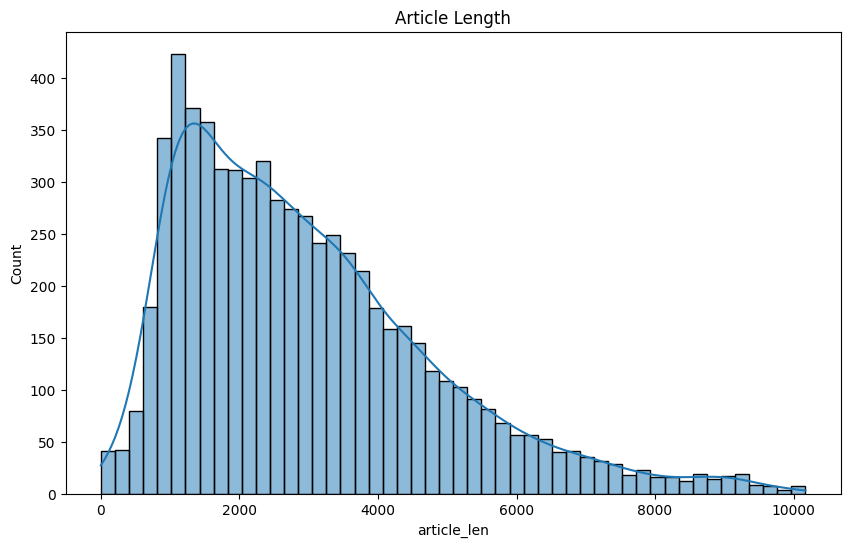

,article_len
count,6566.000000
mean,2968.537009
std,1850.057023
min,0.000000
25%,1516.000000
50%,2578.500000
75%,3947.750000
max,10171.000000


In [12]:
from utils.general import remove_over_percentile

#apply helper function from utils module
ds_99pct, ds_outliers = remove_over_percentile(ds, 'article_len', .99)

fig = plt.figure(figsize=(10, 6))

# Plot the first histogram on the first subplot
sns.histplot(ds_99pct['article_len'], bins=50, kde=True)
plt.title('Article Length')


# Display the plots
plt.show()

display(ds_99pct.describe())

Now we have a more reasonable dataset to work with. Given this is an illustration of the process and thinking, we're going to go one step further an subset the data down to 50 randomly selected articles - mostly because I'm terrified of my GPT4 bill! 

,article_len
count,50.000000
mean,3052.040000
std,1826.751862
min,123.000000
25%,1568.500000
50%,2691.000000
75%,4452.000000
max,6692.000000


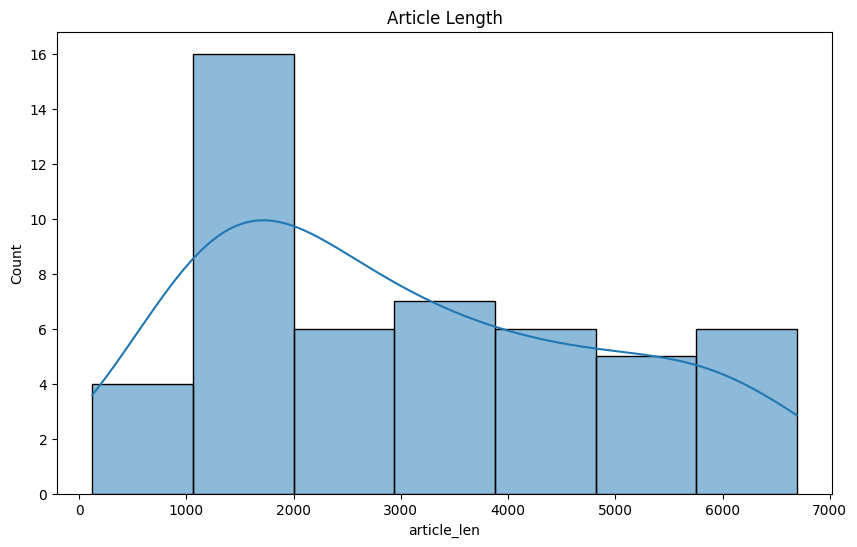

In [15]:
# select a random 50 unique doc_ids and subset both the ds_99pct and new_df dataframes using these IDs
random.seed(42)
random_doc_ids = random.sample(list(ds_99pct['doc_id'].unique()), 50)

# Subset the DataFrames
ds_subset = ds_99pct[ds_99pct['doc_id'].isin(random_doc_ids)]

Now that we have our dataset, let's start talking about tokens, why it's good to know about them, and how they relate to designing a RAG system.

## Words, Token and Contexts

Despite feeling like LLMs converse in our language, there's a few things that go in behind the scenes that translate our verbiage into something an algorithm understands. 

Firstly, the text is `tokenized`, which means words are split into a list of `tokens`. Think of this a bit like stemming in NLP. For shorter words, the ratio of tokens to words can be 1:1 (i.e. the word = the token), but for longer, or more complex words the ratio can be far higher. 

These lists are then mapped into numerical vectors that the algorithm can understand. For a given corpus, we could work out the exact ratio - in fact, let's do that!

First we will apply the appropriate encoding to the text, then we simply sum up the number of tokens and words in the corpus and calculate the number of tokens / word.

In [19]:
# run the tokeniser over the articles and store the results in the DataFrame
encoding = tk.encoding_for_model('gpt-3.5-turbo')

article_tokens = ds_subset['article'].apply(encoding.encode)

# check if columns already exist
if 'article_tokens' in ds_99pct.columns:
    ds_subset = ds_subset.drop(columns=['article_tokens'])

ds_subset = ds_subset.assign(article_tokens=article_tokens)
ds_subset['article_tk_len'] = ds_subset['article_tokens'].apply(lambda x: len(x))
ds_subset['token_ratio'] = ds_subset['article_tk_len']/ds_subset['article_len']

total_words = ds_subset['article_len'].sum()
total_tokens = ds_subset['article_tk_len'].sum()

ratio = total_tokens/total_words

print(f'The ratio of tokens to words is {ratio:.2f}')

The ratio of tokens to words is 1.34


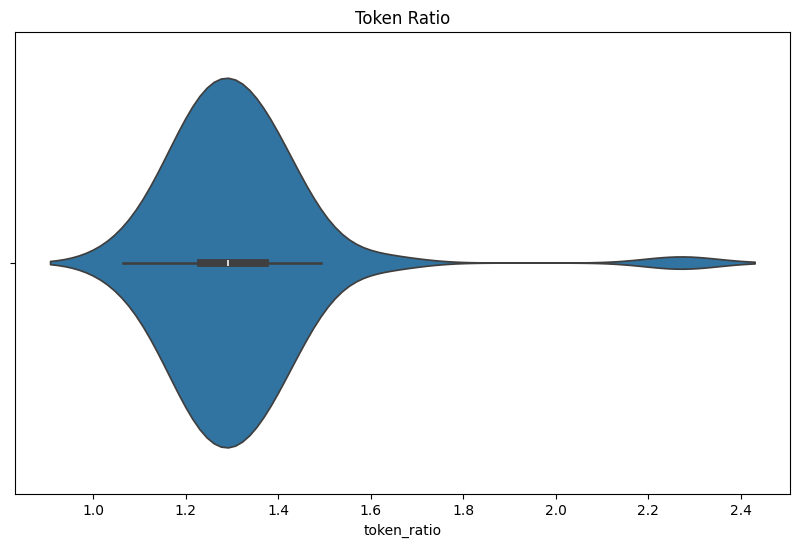

In [20]:
# create a violin plot of token ratios
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='token_ratio', data=ds_subset)
plt.title('Token Ratio')
plt.show()

# TODO: Wouldn't it be fun to find two classes of articles with different token ratios and compare them?
